# Notebook that generates my README

In [1]:
from datetime import datetime

import jinja2
import matplotlib.pyplot as plt
import mplcyberpunk

import generate_data as gd

plt.style.use("cyberpunk")

In [2]:
_ = await gd.generate_data()

2025-11-24 12:06:21,126 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-kasa/repos?type=sources "HTTP/1.1 200 OK"


2025-11-24 12:06:21,212 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/topocm/repos?type=sources "HTTP/1.1 200 OK"


2025-11-24 12:06:21,216 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/pipefunc/repos?type=sources "HTTP/1.1 200 OK"


2025-11-24 12:06:21,273 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-adaptive/repos?type=sources "HTTP/1.1 200 OK"


2025-11-24 12:06:21,312 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/kwant-project/repos?type=sources "HTTP/1.1 200 OK"


2025-11-24 12:06:21,576 INFO:httpx:HTTP Request: GET https://api.github.com/users/basnijholt/repos?type=sources "HTTP/1.1 200 OK"


2025-11-24 12:06:22,054 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=2 "HTTP/1.1 200 OK"


2025-11-24 12:06:22,522 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=3 "HTTP/1.1 200 OK"


2025-11-24 12:06:23,173 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=4 "HTTP/1.1 200 OK"


2025-11-24 12:06:23,650 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=5 "HTTP/1.1 200 OK"


2025-11-24 12:06:24,133 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=6 "HTTP/1.1 200 OK"


2025-11-24 12:06:24,563 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=7 "HTTP/1.1 200 OK"


2025-11-24 12:06:25,061 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=8 "HTTP/1.1 200 OK"


2025-11-24 12:06:25,580 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=9 "HTTP/1.1 200 OK"


2025-11-24 12:06:26,048 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=10 "HTTP/1.1 200 OK"


2025-11-24 12:06:26,650 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=11 "HTTP/1.1 200 OK"


2025-11-24 12:06:27,202 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=12 "HTTP/1.1 200 OK"


2025-11-24 12:06:27,943 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=13 "HTTP/1.1 200 OK"


2025-11-24 12:06:28,415 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=14 "HTTP/1.1 200 OK"


2025-11-24 12:06:28,695 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:28,919 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:29,136 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:29,374 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:29,577 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:29,798 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:30,034 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:30,255 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:30,503 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:30,692 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:30,900 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:31,107 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:31,373 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:31,641 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:31,881 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:32,100 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:32,325 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:32,608 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:32,816 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:33,012 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:33,211 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:33,552 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:33,751 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:33,938 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:34,144 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:34,345 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:34,529 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:34,727 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:34,955 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:35,195 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:35,814 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:36,034 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:36,237 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:36,478 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:36,697 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:36,997 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:37,242 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:37,467 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:37,664 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:37,886 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:38,068 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:38,286 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:38,492 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:38,702 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:38,942 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:39,232 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:39,511 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:39,746 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:39,957 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:40,176 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:40,462 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:40,627 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:40,839 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:41,114 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:41,435 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:41,671 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:41,845 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:42,028 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:42,294 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:42,485 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:42,764 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:42,933 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:43,215 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:43,431 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:43,643 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:43,832 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:44,154 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:44,374 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:44,596 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:44,850 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:45,083 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:45,313 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:45,521 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:45,920 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:46,106 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:46,335 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:46,549 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:46,818 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:47,232 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:47,417 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:47,619 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:47,797 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:47,975 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:48,210 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:48,455 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:48,732 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:48,995 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:49,232 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:49,485 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:49,713 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:50,004 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:50,214 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:50,539 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:50,804 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:50,998 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:51,261 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:51,502 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:51,756 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:51,957 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:52,164 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:52,370 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:52,558 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:52,741 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:52,978 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:53,171 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:53,373 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:53,572 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:53,808 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:54,016 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:54,172 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:54,349 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:54,518 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:54,710 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:54,964 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:55,165 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:55,466 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:55,688 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:55,924 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:56,222 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:56,459 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:56,692 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:56,904 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:57,103 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:57,277 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:57,526 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:57,823 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:58,047 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:58,227 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:58,420 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:58,607 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-11-24 12:06:58,789 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


In [3]:
data = gd.load_data()
repos = data.repos
stargazers = data.stargazers

## Number of stars ⭐️

In [4]:
most_stars_strs = [
    f"{i+1}. [{repo['full_name']}](https://github.com/{repo['full_name']}/), {repo['stargazers_count']} ⭐️s"
    for i, repo in enumerate(stargazers[:20])
]

most_stars_strs_summary, most_stars_strs_rest = gd.split(most_stars_strs, 5)

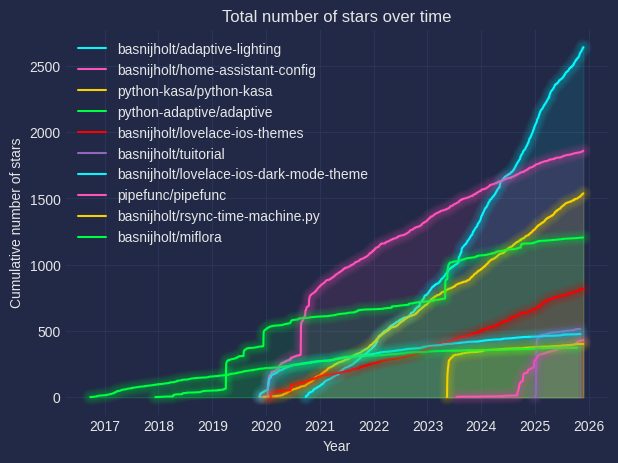

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")

for star_info in stargazers[:10]:
    dates = star_info["dates"]
    n_stars = list(range(1, len(dates) + 1))
    ax.plot(dates, n_stars, label=star_info["full_name"])
ax.legend()
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time_per_repo.png")

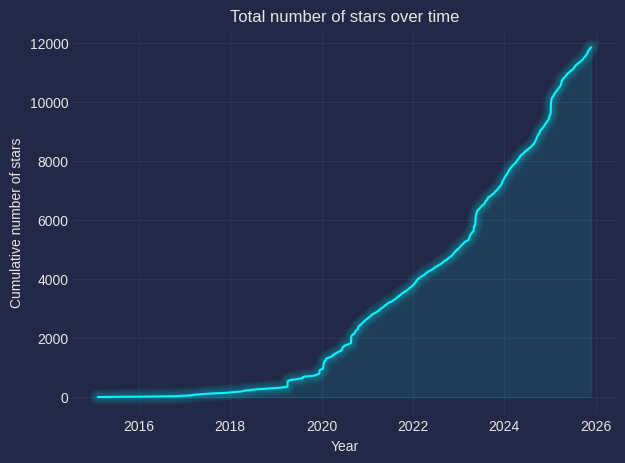

In [6]:
all_dates = sorted([date for star_info in stargazers for date in star_info["dates"]])
n_stars = list(range(1, len(all_dates) + 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(all_dates, n_stars)
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time.png")

In [7]:
# gd.to_plotly_json()

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# with open("data/traces_data.json", "r") as infile:
#     traces_data = json.load(infile)
# fig = make_subplots()
# for trace_data in traces_data:
#     trace = go.Scatter(**trace_data)
#     fig.add_trace(trace)
# fig.update_layout(
#     title="Cumulative number of stars over time",
#     xaxis_title="Date",
#     yaxis_title="Number of stars",
# )
# fig.show()


## Render template

In [8]:
with open("README.jinja2", "r") as f:
  template = f.read()
txt = jinja2.Template(template).render(
    most_stars_strs_summary=most_stars_strs_summary,
    most_stars_strs_rest=most_stars_strs_rest,
    now=str(datetime.now()),
)
with open("README.md", "w") as f:
    f.write(txt)
print(txt)

# Bas Nijholt 👋

<center>
  <table>
    <tr>
        <td><img width="300px" align="left" src="https://github-readme-stats.vercel.app/api/top-langs/?username=basnijholt&hide=TeX,Jupyter%20Notebook&layout=compact&theme=radical" /></td>
        <td><img align='right' src="https://github-readme-stats.vercel.app/api?username=basnijholt&show_icons=true&theme=radical" width="380"></td>
    </tr>
  </table>
</center>

- 👷🏻‍♂️ Currently at [IonQ](https://ionq.com/), doing my bit in building a quantum computer, before that I was at [Microsoft Quantum](https://quantum.microsoft.com/).
- 🌟 A deep dive into computational topological quantum mechanics earned me [my PhD](https://github.com/basnijholt/thesis).
- 🎨 I've crafted [a](https://github.com/basnijholt/adaptive-lighting) [few](https://github.com/basnijholt/aiokef) [libraries](https://github.com/basnijholt/miflora) for Home Assistant, making home automation a bit more fun.
- ⚒️ Made other tools [speed up](https://github.com/python-adaptive/adap